In [95]:
import pandas as pd
import numpy as np
import scipy.stats as sstats
import statsmodels as sm
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

df = pd.read_csv('ab_test.csv')
print(df.shape)

(320415, 10)


In [96]:
df.columns

Index(['AB_TEST', 'USER_ID', 'TOPNEWS_IMPRESSION_COUNT',
       'TOPNEWS_CLICKED_COUNT', 'ADS_IMPRESSION_TOPNEWS_COUNT',
       'ADS_CLICKED_TOPNEWS_COUNT', 'MYNEWS_COUNT',
       'ARTICLE_MYNEWS_CLICKED_COUNT', 'ADS_IMPRESSION_MYNEWS_COUNT',
       'ADS_CLICKED_MYNEWS_COUNT'],
      dtype='object')

#### Checking for missing values & dropping if any

In [97]:
df.isna().sum()

AB_TEST                         0
USER_ID                         2
TOPNEWS_IMPRESSION_COUNT        0
TOPNEWS_CLICKED_COUNT           0
ADS_IMPRESSION_TOPNEWS_COUNT    0
ADS_CLICKED_TOPNEWS_COUNT       0
MYNEWS_COUNT                    0
ARTICLE_MYNEWS_CLICKED_COUNT    0
ADS_IMPRESSION_MYNEWS_COUNT     0
ADS_CLICKED_MYNEWS_COUNT        0
dtype: int64

In [98]:
df.dropna(inplace=True)
df.shape

(320413, 10)

In [99]:
## Ensuring that the data contains only unique users.
df['USER_ID'].nunique()

320118

#### The data contains mostly unique users. There are less than 0.09% of duplicates. Hence removing the duplicates.

In [100]:
df_new = df.drop_duplicates(subset=['USER_ID'])
df_new.shape

(320118, 10)

#### Checking the split of control & experiment groups

In [101]:
df_new['AB_TEST'].value_counts()

Test       168532
Control    151586
Name: AB_TEST, dtype: int64

#### Aggregating Impressions & Clicks

In [102]:
## Define New Variables
df_new['Total_Ads_Imp']=df_new['ADS_IMPRESSION_TOPNEWS_COUNT']+df_new['ADS_IMPRESSION_MYNEWS_COUNT']
df_new['Total_News_Imp']=df_new['TOPNEWS_IMPRESSION_COUNT']+df_new['MYNEWS_COUNT']
df_new['Total_Ads_Clicked']=df_new['ADS_CLICKED_TOPNEWS_COUNT']+df_new['ADS_CLICKED_MYNEWS_COUNT']
df_new['Total_News_Clicked']=df_new['TOPNEWS_CLICKED_COUNT']+df_new['ARTICLE_MYNEWS_CLICKED_COUNT']

In [103]:
pd.DataFrame(df_new.describe()).T

,count,mean,std,min,25%,50%,75%,max
TOPNEWS_IMPRESSION_COUNT,320118.0,24.777638,64.568742,0.0,0.0,5.0,21.0,6307.0
TOPNEWS_CLICKED_COUNT,320118.0,2.204340,5.991379,0.0,0.0,0.0,2.0,293.0
ADS_IMPRESSION_TOPNEWS_COUNT,320118.0,4.094649,12.468467,0.0,0.0,0.0,3.0,371.0
ADS_CLICKED_TOPNEWS_COUNT,320118.0,0.043368,0.358782,0.0,0.0,0.0,0.0,22.0
MYNEWS_COUNT,320118.0,25.691470,215.441378,0.0,0.0,0.0,1.0,22126.0
ARTICLE_MYNEWS_CLICKED_COUNT,320118.0,1.308102,7.934788,0.0,0.0,0.0,0.0,535.0
ADS_IMPRESSION_MYNEWS_COUNT,320118.0,3.056298,25.896082,0.0,0.0,0.0,0.0,2027.0
ADS_CLICKED_MYNEWS_COUNT,320118.0,0.019371,0.334934,0.0,0.0,0.0,0.0,106.0
Total_Ads_Imp,320118.0,7.150947,33.828390,0.0,0.0,0.0,3.0,2028.0
Total_News_Imp,320118.0,50.469108,249.185918,0.0,0.0,5.0,26.0,23003.0


##### The 25th percentile of all columns are 0. 
##### This suggests that the sample population that were a part of the experiment were not active users of the app itself.
##### Since the hypothesis is to identify change in UI experience, we can ignore people who have not opened the app at all.
##### Including a sample population which have not opened the app will lead to a bias when we are analyzing UI experience.
##### Removing outliers & samples with 0 impressions will provide an unbiased sample for analysis.

In [247]:
### Identifying sample size with zero overall impressions. 
zero_impressions = len(df_new[(df_new['Total_News_Imp']==0)&(df_new['Total_Ads_Imp']==0)])
total_data_size = len(df_new)
print("Users With Zero Impressions:", zero_impressions, "\nPercentage Of Total Data:", format((zero_impressions/total_data_size * 100),".2f"), "%")

Users With Zero Impressions: 85124 
Percentage Of Total Data: 26.59 %


#### Removing All Zero Impression Users

In [248]:
df_valid = df_new[~((df_new['Total_News_Imp']==0)&(df_new['Total_Ads_Imp']==0))]
df_valid.shape

(234994, 14)

In [251]:
### Evaluating the size of Zero Total_Ads_Impressions
df_valid[df_valid['Total_Ads_Imp']==0].shape

(96828, 14)

In [252]:
df_test = df_valid[df_valid['AB_TEST']=='Test']
df_control = df_valid[df_valid['AB_TEST']=='Control']

In [253]:
df_test.shape

(120800, 14)

##### Test Group

In [254]:
pd.DataFrame(df_test.describe()).T

,count,mean,std,min,25%,50%,75%,max
TOPNEWS_IMPRESSION_COUNT,120800.0,32.742334,72.739398,0.0,3.0,11.0,30.0,6307.0
TOPNEWS_CLICKED_COUNT,120800.0,3.036904,7.203524,0.0,0.0,1.0,3.0,249.0
ADS_IMPRESSION_TOPNEWS_COUNT,120800.0,5.052161,13.642765,0.0,0.0,1.0,4.0,368.0
ADS_CLICKED_TOPNEWS_COUNT,120800.0,0.050224,0.380511,0.0,0.0,0.0,0.0,22.0
MYNEWS_COUNT,120800.0,28.321498,229.315858,0.0,0.0,0.0,2.0,18792.0
ARTICLE_MYNEWS_CLICKED_COUNT,120800.0,1.404180,8.504191,0.0,0.0,0.0,0.0,535.0
ADS_IMPRESSION_MYNEWS_COUNT,120800.0,2.534371,25.779682,0.0,0.0,0.0,0.0,2027.0
ADS_CLICKED_MYNEWS_COUNT,120800.0,0.011937,0.245031,0.0,0.0,0.0,0.0,40.0
Total_Ads_Imp,120800.0,7.586531,33.426998,0.0,0.0,1.0,5.0,2028.0
Total_News_Imp,120800.0,61.063833,263.674918,0.0,4.0,13.0,39.0,18890.0


##### Control Group

In [255]:
pd.DataFrame(df_control.describe()).T

,count,mean,std,min,25%,50%,75%,max
TOPNEWS_IMPRESSION_COUNT,114194.0,34.822267,73.922519,0.0,3.0,11.0,32.0,1940.0
TOPNEWS_CLICKED_COUNT,114194.0,2.930495,6.379948,0.0,0.0,1.0,3.0,293.0
ADS_IMPRESSION_TOPNEWS_COUNT,114194.0,6.134035,14.875777,0.0,0.0,1.0,5.0,371.0
ADS_CLICKED_TOPNEWS_COUNT,114194.0,0.068445,0.453441,0.0,0.0,0.0,0.0,22.0
MYNEWS_COUNT,114194.0,42.060572,271.514131,0.0,0.0,0.0,8.0,22126.0
ARTICLE_MYNEWS_CLICKED_COUNT,114194.0,2.181542,9.896710,0.0,0.0,0.0,1.0,500.0
ADS_IMPRESSION_MYNEWS_COUNT,114194.0,5.886684,34.082411,0.0,0.0,0.0,1.0,1747.0
ADS_CLICKED_MYNEWS_COUNT,114194.0,0.041675,0.500126,0.0,0.0,0.0,0.0,106.0
Total_Ads_Imp,114194.0,12.020719,44.316414,0.0,0.0,1.0,7.0,1854.0
Total_News_Imp,114194.0,76.882840,312.738454,0.0,4.0,12.0,46.0,23003.0


#### A significant diffference in mean, median, max values suggests, there are outliers in the data.
#### Outlier Boundary = Q3 + 1.5 IQR
#### We will cap all upward outliers at value of the outlier boundary.

In [201]:
def treat_outliers(df_sub:pd.DataFrame):
    df_final=pd.DataFrame()
    cols= ['TOPNEWS_IMPRESSION_COUNT', 'Total_Ads_Imp', 'Total_News_Imp', 'Total_Ads_Clicked', 'Total_News_Clicked']
    for col in cols:
        q1 = np.percentile(df_sub[col],25)
        q3 = np.percentile(df_sub[col],75)
        iqr = q3-q1
        outlier_cap = q3 + (1.5*iqr)
        df_final[col] = np.where(df_sub[col]>outlier_cap, outlier_cap, df_sub[col])
    return df_final

In [202]:
clean_test = treat_outliers(df_test)
clean_control = treat_outliers(df_control)

In [198]:
### Adding a Success-Metric
clean_test['Ads_Yes']=(clean_test['Total_Ads_Imp']>0).astype(int)
clean_control['Ads_Yes']=(clean_control['Total_Ads_Imp']>0).astype(int)
# clean_test.at[:,"Group"]="Test"
# clean_control.at[:,"Group"]="Control"
# df_clean = pd.concat([clean_test,clean_control])
# df_clean.head(5)
df_clean.to_csv('df_clean.csv', index=False)

In [203]:
pd.DataFrame(clean_test.describe()).T

,count,mean,std,min,25%,50%,75%,max
TOPNEWS_IMPRESSION_COUNT,120800.0,20.866043,23.144631,0.0,3.0,11.0,30.0,70.5
Total_Ads_Imp,120800.0,3.117695,4.317144,0.0,0.0,1.0,5.0,12.5
Total_News_Imp,120800.0,26.988464,30.801633,0.0,4.0,13.0,39.0,91.5
Total_Ads_Clicked,120800.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Total_News_Clicked,120800.0,2.570050,3.300685,0.0,0.0,1.0,4.0,10.0


In [204]:
pd.DataFrame(clean_control.describe()).T

,count,mean,std,min,25%,50%,75%,max
TOPNEWS_IMPRESSION_COUNT,114194.0,22.053015,25.060955,0.0,3.0,11.0,32.0,75.5
Total_Ads_Imp,114194.0,4.642656,6.270731,0.0,0.0,1.0,7.0,17.5
Total_News_Imp,114194.0,31.216649,37.692420,0.0,4.0,12.0,46.0,109.0
Total_Ads_Clicked,114194.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Total_News_Clicked,114194.0,2.794043,3.467166,0.0,0.0,1.0,4.0,10.0


#### The outliers have been removed and yet, mean is more than double the value of the median. This suggests that data is highly right-skewed.
#### Also mean of control-group appear to be higher than that of the test group. 
#### The clicks are almost negligent, hence will proceed with analysing impressions alone.

#### H0: The new UI did not make any significant improvement in the impressions.
#### H1: The new UI improved the impression count

In [379]:
## Checking the mean & standard-deviation of control & test population after clean-up
print("Top-News Impressions")
print("\nMean\nControl\t\tTest\n",format(clean_control['TOPNEWS_IMPRESSION_COUNT'].mean(),".3f"),"\t",format(clean_test['TOPNEWS_IMPRESSION_COUNT'].mean(),".3f"))
print("\nStandard Deviation\nControl\t\tTest\n",format(clean_control['TOPNEWS_IMPRESSION_COUNT'].std(),".3f"),"\t",format(clean_test['TOPNEWS_IMPRESSION_COUNT'].std(),".3f"))

print("\nTotal-News Impressions")
print("\nMean\nControl\t\tTest\n",format(clean_control['Total_News_Imp'].mean(),".3f"),"\t",format(clean_test['Total_News_Imp'].mean(),".3f"))
print("\nStandard Deviation\nControl\t\tTest\n",format(clean_control['Total_News_Imp'].std(),".3f"),"\t",format(clean_test['Total_News_Imp'].std(),".3f"))

print("\nTotal Ad Impressions")
print("\nMean\nControl\t\tTest\n",format(clean_control['Total_Ads_Imp'].mean(),".3f"),"\t\t",format(clean_test['Total_Ads_Imp'].mean(),".3f"))
print("\nStandard Deviation\nControl\t\tTest\n",format(clean_control['Total_Ads_Imp'].std(),".3f"),"\t\t",format(clean_test['Total_Ads_Imp'].std(),".3f"))

Top-News Impressions

Mean
Control		Test
 22.053 	 20.866

Standard Deviation
Control		Test
 25.061 	 23.145

Total-News Impressions

Mean
Control		Test
 31.217 	 26.988

Standard Deviation
Control		Test
 37.692 	 30.802

Total Ad Impressions

Mean
Control		Test
 4.643 		 3.118

Standard Deviation
Control		Test
 6.271 		 4.317


In [163]:
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [413]:
# Creating the sampling distribution of difference in means

def stat_test(control,test,metric):
    means_diff = []
    wstats=[]
    size = df.shape[0]
    for _ in range(10000):  
        test_sample = test.sample(1000, replace=False)
        control_sample = control.sample(1000, replace=False)
        control_mean = control_sample[metric].mean()
        test_mean = test_sample[metric].mean()
        w, p = sstats.ttest_ind(test_sample[metric],control_sample[metric], equal_var=False)
        wstats.append(w)
        means_diff.append(test_mean - control_mean)

    print("Mean Of Test Group Better Than Control:\n",format((sum(np.array(means_diff)>0)/10000)*100,".2f"),"%")
    print("W-Stats Indicating Test Group Is Better Than Control:\n",(sum(np.array(wstats)>1.645)/10000)*100,"%")
    plt.figure(figsize = (8,4), dpi = 100)
    plt.hist(means_diff, bins = 25)
    plt.title("Histogram Of Difference In Means")
    plt.show()

#### Probability Of Test Group Being Better Than Control Group

Mean Of Test Group Better Than Control:
 12.91 %
W-Stats Indicating Test Group Is Better Than Control:
 0.25 %


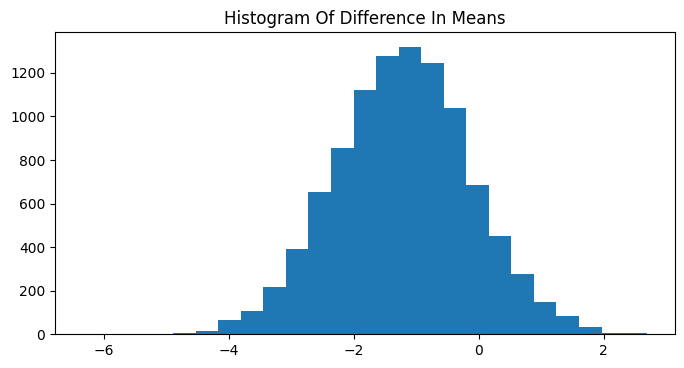

In [414]:
stat_test(clean_control,clean_test,'TOPNEWS_IMPRESSION_COUNT')

Mean Of Test Group Better Than Control:
 0.23 %
W-Stats Indicating Test Group Is Better Than Control:
 0.0 %


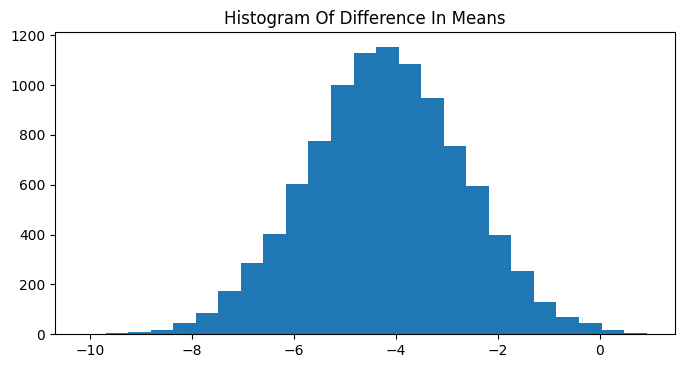

In [415]:
stat_test(clean_control,clean_test,'Total_News_Imp')

Mean Of Test Group Better Than Control:
 0.00 %
W-Stats Indicating Test Group Is Better Than Control:
 0.0 %


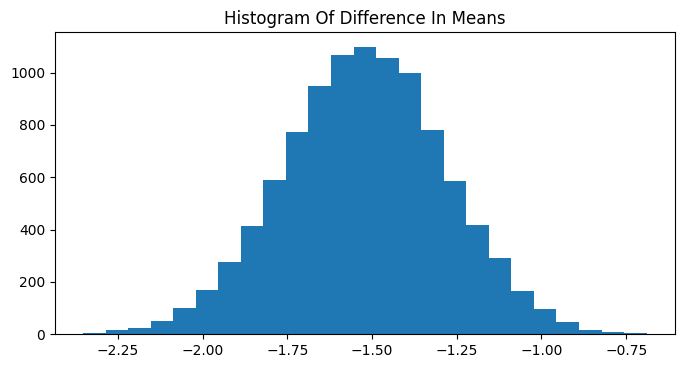

In [416]:
stat_test(clean_control,clean_test,'Total_Ads_Imp')

Mean Of Test Group Better Than Control:
 0.80 %
W-Stats Indicating Test Group Is Better Than Control:
 0.0 %


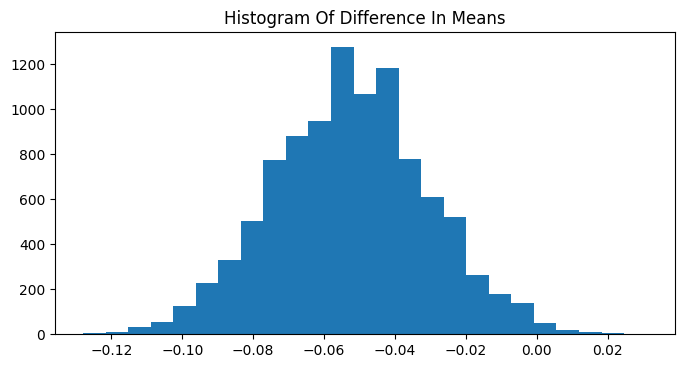

In [417]:
### Adding a Success-Metric
clean_test['Ads_Yes']=(clean_test['Total_Ads_Imp']>0).astype(int)
clean_control['Ads_Yes']=(clean_control['Total_Ads_Imp']>0).astype(int)

stat_test(clean_control,clean_test,'Ads_Yes')

### A/B Testing Of Success Metric

In [373]:
## The median Ad-Impression in both control & test group is 0. 
## If a person has got atleast 1 Ad impression, it means he has browsed through news articles. 
## We need more users who have viewed an ad, than the same user viewing multiple ads. 
## So we take user-id count of people who have had atleast an Ad impression.

clean_test.loc[:,"Group"]="Test"
clean_control.loc[:,"Group"]="Control"
ab_test = pd.concat([clean_test,clean_control])
ab_test = ab_test.reset_index(drop=True)
ab_test.head(2)

,TOPNEWS_IMPRESSION_COUNT,Total_Ads_Imp,Total_News_Imp,Total_Ads_Clicked,Total_News_Clicked,Ads_Yes,Group
0,4.0,0.0,4.0,0.0,0.0,0,Test
1,70.5,0.0,91.5,0.0,10.0,0,Test


In [374]:
conversion_rates = ab_test.groupby('Group')['Ads_Yes']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['success_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,success_rate,std_deviation,std_error
Group,,,
Control,0.615,0.487,0.001
Test,0.562,0.496,0.001


In [375]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
controls = clean_control['Ads_Yes']
treatments = clean_test['Ads_Yes']
num_ctrl = controls.count()
num_treat = treatments.count()
successes = [controls.sum(), treatments.sum()]
tots = [num_ctrl, num_treat]

z_stat, pval = proportions_ztest(successes, nobs=tots)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=tots, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 25.93
p-value: 0.000
ci 95% for control group: [0.612, 0.618]
ci 95% for treatment group: [0.560, 0.565]


In [376]:
## Random Sample
test_sample = clean_test.sample(1000, replace=False)
control_sample = clean_control.sample(1000, replace=False)


controls = control_sample['Ads_Yes']
treatments = test_sample['Ads_Yes']
num_ctrl = controls.count()
num_treat = treatments.count()
successes = [controls.sum(), treatments.sum()]
tots = [num_ctrl, num_treat]

z_stat, pval = proportions_ztest(successes, nobs=tots)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=tots, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 2.14
p-value: 0.033
ci 95% for control group: [0.585, 0.645]
ci 95% for treatment group: [0.537, 0.599]


### Conclusion: 
##### At alpha value of 0.05, the z-critical value is 1.64. 
##### With a p-value < 0.05, the H0 that there is no change in metrics can be rejected.
##### The z-statistics obtained is consistently higher than the critical value, implying there is strong evidence that control-group is better than treatment group.

In [436]:
## Random Sample for A/A Testing
test_sample_one = clean_test.sample(1000, replace=False)
remaining_indexes = list(set(clean_test.index).difference(set(test_sample_one.index)))
test_sample_two = clean_test.iloc[remaining_indexes,:].sample(1000, replace=False)

controls = test_sample_one['Ads_Yes']
treatments = test_sample_two['Ads_Yes']
num_ctrl = controls.count()
num_treat = treatments.count()
successes = [controls.sum(), treatments.sum()]
tots = [num_ctrl, num_treat]

z_stat, pval = proportions_ztest(successes, nobs=tots)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=tots, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.23
p-value: 0.822
ci 95% for control group: [0.523, 0.585]
ci 95% for treatment group: [0.528, 0.590]


##### NOTE: The A/A testing on 2 samples from the treatment group has a high p-value, implying that there is no significant difference within the treatment group and the user experience is same across.